# Predicting the SPY
---

- [0. Data Processing]
- [1. Neural Network]
- [2. 1D Convolution Neural Network]

The models get the following:
- normalised data
    - Neural Net: 0.251
    - Conv 1D Neural Net: 0.36
    - LSTM: 0.32


## 0. Data Processing

The data is 5min intervals.

The target variable for this will be binary. Does the SPY go up or down in the next 30min. Will ingest the last 2 hours of data as input.


In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03


In [3]:
df.datetime.agg(['max','min'])

max   2022-03-25 14:10:00
min   2022-01-03 09:00:00
Name: datetime, dtype: datetime64[ns]

In [4]:
df.shape

(10965, 10)

In [5]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,date,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,2022-01-03,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,2022-01-03,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,2022-01-03,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,2022-01-03,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,2022-01-03,300.0,0.000609


In [6]:
# min_max = df.groupby('date')['close'].agg(['min','max']).shift(1).reset_index().rename(columns={'min':'previous_day_min',
#                                                                                                 'max':'previous_day_max'})
# df = df.merge(min_max,on='date')
# df['previous_day_max_ratio'] = df['close']/df['previous_day_max']
# df['previous_day_min_ratio'] = df['close']/df['previous_day_min']

<AxesSubplot:xlabel='datetime'>

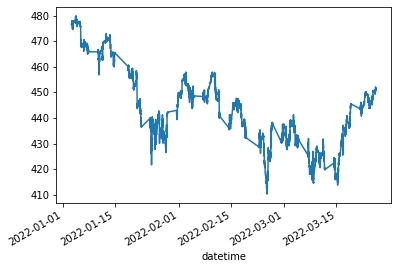

In [7]:
df.set_index('datetime')['close'].plot()

In [8]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()
growth = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    growth_data = df.loc[t+1:t+6,'close_diff'].sum()
    
    X.append(lookback_data)
    y.append(outcome_data)
    growth.append(growth_data)
    
    t+=1

10965 ticks found


In [9]:
y = np.array(y).reshape(-1,1)
y.shape

(10939, 1)

In [10]:
growth = np.array(growth).reshape(-1,1)
growth.shape

(10939, 1)

In [11]:
X = np.stack(X)
X.shape

(10939, 21, 5)

In [12]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

with open('./data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

## 1.0 Neural Network

In [13]:
import tensorflow as tf
from tensorflow import keras

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# with open('./data/X_train_2.npy','rb') as f:
#     X_train = np.load(f).astype('float32')
    
# with open('./data/X_test_2.npy','rb') as f:
#     X_test = np.load(f).astype('float32')
    
# with open('./data/y_train_2.npy','rb') as f:
#     y_train = np.load(f).astype('float32')

# with open('./data/y_test_2.npy','rb') as f:
#     y_test = np.load(f).astype('float32')

In [14]:
X_train.shape

(6000, 21, 5)

In [15]:
y_train.shape

(6000, 1)

In [16]:
X_test.shape

(4939, 21, 5)

In [17]:
y_test.shape

(4939, 1)

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    #keras.layers.Dense(21,activation='relu'),
    keras.layers.Dense(20,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [19]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [20]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [21]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100
120/120 - 1s - loss: 0.6776 - auc: 0.5706 - val_loss: 0.2342 - val_auc: 0.6222 - 805ms/epoch - 7ms/step
Epoch 2/100
120/120 - 0s - loss: 0.4281 - auc: 0.5887 - val_loss: 0.2205 - val_auc: 0.6268 - 157ms/epoch - 1ms/step
Epoch 3/100
120/120 - 0s - loss: 0.3910 - auc: 0.5966 - val_loss: 0.2148 - val_auc: 0.6279 - 168ms/epoch - 1ms/step
Epoch 4/100
120/120 - 0s - loss: 0.3538 - auc: 0.6054 - val_loss: 0.2085 - val_auc: 0.6269 - 163ms/epoch - 1ms/step
Epoch 5/100
120/120 - 0s - loss: 0.3139 - auc: 0.6063 - val_loss: 0.2033 - val_auc: 0.6295 - 160ms/epoch - 1ms/step
Epoch 6/100
120/120 - 0s - loss: 0.2776 - auc: 0.6116 - val_loss: 0.1989 - val_auc: 0.6328 - 150ms/epoch - 1ms/step
Epoch 7/100
120/120 - 0s - loss: 0.2550 - auc: 0.6082 - val_loss: 0.1960 - val_auc: 0.6321 - 152ms/epoch - 1ms/step
Epoch 8/100
120/120 - 0s - loss: 0.2458 - auc: 0.6143 - val_loss: 0.1945 - val_auc: 0.6312 - 150ms/epoch - 1ms/step
Epoch 9/100
120/120 - 0s - loss: 0.2415 - auc: 0.6177 - val_loss: 0.1917

120/120 - 0s - loss: 0.1370 - auc: 0.6642 - val_loss: 0.1608 - val_auc: 0.6370 - 164ms/epoch - 1ms/step
Epoch 72/100
120/120 - 0s - loss: 0.1368 - auc: 0.6642 - val_loss: 0.1603 - val_auc: 0.6424 - 149ms/epoch - 1ms/step
Epoch 73/100
120/120 - 0s - loss: 0.1375 - auc: 0.6741 - val_loss: 0.1596 - val_auc: 0.6474 - 149ms/epoch - 1ms/step
Epoch 74/100
120/120 - 0s - loss: 0.1369 - auc: 0.6627 - val_loss: 0.1602 - val_auc: 0.6468 - 148ms/epoch - 1ms/step
Epoch 75/100
120/120 - 0s - loss: 0.1361 - auc: 0.6692 - val_loss: 0.1597 - val_auc: 0.6365 - 152ms/epoch - 1ms/step
Epoch 76/100
120/120 - 0s - loss: 0.1356 - auc: 0.6695 - val_loss: 0.1606 - val_auc: 0.6434 - 148ms/epoch - 1ms/step
Epoch 77/100
120/120 - 0s - loss: 0.1359 - auc: 0.6691 - val_loss: 0.1597 - val_auc: 0.6504 - 147ms/epoch - 1ms/step
Epoch 78/100
120/120 - 0s - loss: 0.1355 - auc: 0.6729 - val_loss: 0.1603 - val_auc: 0.6439 - 149ms/epoch - 1ms/step
Epoch 79/100
120/120 - 0s - loss: 0.1359 - auc: 0.6743 - val_loss: 0.1620 - v

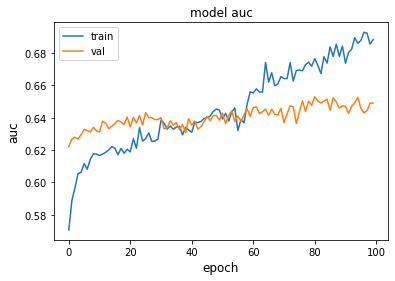

In [22]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score

test_gini = 2*roc_auc_score(y_test,model.predict(X_test))-1
train_gini = 2*roc_auc_score(y_train,model.predict(X_train))-1

print(f'Train GINI:{train_gini:0.3f}, Test GINI:{test_gini:0.3f}')

188/188 [==============================] - 0s 597us/step
Train GINI:0.401, Test GINI:0.300


155/155 [==============================] - 0s 615us/step


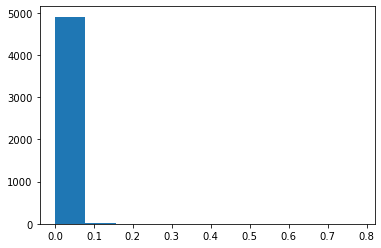

In [24]:
from matplotlib import pyplot as plt
axes = plt.hist(model.predict(X_test),label='test')
#axes.hist(model.predict(X_train),label='train')
plt.show()

188/188 [==============================] - 0s 645us/step


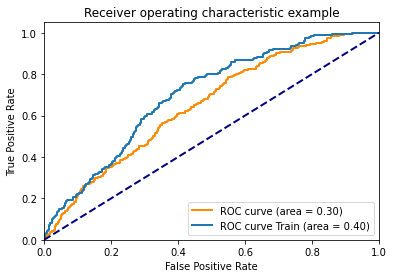

In [26]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train))

plt.figure()
lw = 2
roc = 2*roc_auc_score(y_test,model.predict(X_test))-1
roc_train = 2*roc_auc_score(y_train,model.predict(X_train))-1

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc,
)

plt.plot(
    fpr_train,
    tpr_train,
    #color="darkorange",
    lw=lw,
    label="ROC curve Train (area = %0.2f)" % roc_train,
)


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## 2.0 1D Convolutional NN

In [27]:
model = keras.Sequential([
    keras.layers.Conv1D(36,2,
                        activation='sigmoid',
                        input_shape=(X_train.shape[1],X_train.shape[2]),padding="valid",groups=1,
                        kernel_regularizer=tf.keras.regularizers.l2(l=.05)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(10,activation='sigmoid'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [28]:
metrics = [
    tf.metrics.AUC(name='auc')
]

#odel.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [29]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [30]:
history = model.fit(X_train,y_train,batch_size=50,epochs=200,verbose=2,validation_data=(X_test,y_test))

Epoch 1/200
120/120 - 1s - loss: 1.0782 - auc: 0.5764 - val_loss: 0.9408 - val_auc: 0.4767 - 1s/epoch - 8ms/step
Epoch 2/200
120/120 - 0s - loss: 0.8888 - auc: 0.5182 - val_loss: 0.8121 - val_auc: 0.4841 - 265ms/epoch - 2ms/step
Epoch 3/200
120/120 - 0s - loss: 0.7604 - auc: 0.5565 - val_loss: 0.7158 - val_auc: 0.5152 - 278ms/epoch - 2ms/step
Epoch 4/200
120/120 - 0s - loss: 0.6672 - auc: 0.5735 - val_loss: 0.6361 - val_auc: 0.5399 - 294ms/epoch - 2ms/step
Epoch 5/200
120/120 - 0s - loss: 0.5942 - auc: 0.5978 - val_loss: 0.5711 - val_auc: 0.5784 - 263ms/epoch - 2ms/step
Epoch 6/200
120/120 - 0s - loss: 0.5352 - auc: 0.6382 - val_loss: 0.5192 - val_auc: 0.5883 - 285ms/epoch - 2ms/step
Epoch 7/200
120/120 - 0s - loss: 0.4870 - auc: 0.6328 - val_loss: 0.4754 - val_auc: 0.5931 - 263ms/epoch - 2ms/step
Epoch 8/200
120/120 - 0s - loss: 0.4457 - auc: 0.6234 - val_loss: 0.4373 - val_auc: 0.5865 - 289ms/epoch - 2ms/step
Epoch 9/200
120/120 - 0s - loss: 0.4096 - auc: 0.6288 - val_loss: 0.4041 - 

Epoch 72/200
120/120 - 0s - loss: 0.1340 - auc: 0.6314 - val_loss: 0.1572 - val_auc: 0.6549 - 265ms/epoch - 2ms/step
Epoch 73/200
120/120 - 0s - loss: 0.1336 - auc: 0.6366 - val_loss: 0.1568 - val_auc: 0.6550 - 258ms/epoch - 2ms/step
Epoch 74/200
120/120 - 0s - loss: 0.1335 - auc: 0.6428 - val_loss: 0.1571 - val_auc: 0.6542 - 264ms/epoch - 2ms/step
Epoch 75/200
120/120 - 0s - loss: 0.1332 - auc: 0.6494 - val_loss: 0.1565 - val_auc: 0.6536 - 267ms/epoch - 2ms/step
Epoch 76/200
120/120 - 0s - loss: 0.1341 - auc: 0.6278 - val_loss: 0.1564 - val_auc: 0.6472 - 279ms/epoch - 2ms/step
Epoch 77/200
120/120 - 0s - loss: 0.1337 - auc: 0.6515 - val_loss: 0.1569 - val_auc: 0.6548 - 264ms/epoch - 2ms/step
Epoch 78/200
120/120 - 0s - loss: 0.1332 - auc: 0.6519 - val_loss: 0.1565 - val_auc: 0.6535 - 284ms/epoch - 2ms/step
Epoch 79/200
120/120 - 0s - loss: 0.1333 - auc: 0.6469 - val_loss: 0.1572 - val_auc: 0.6394 - 258ms/epoch - 2ms/step
Epoch 80/200
120/120 - 0s - loss: 0.1334 - auc: 0.6399 - val_los

Epoch 142/200
120/120 - 0s - loss: 0.1318 - auc: 0.6616 - val_loss: 0.1545 - val_auc: 0.6619 - 271ms/epoch - 2ms/step
Epoch 143/200
120/120 - 0s - loss: 0.1312 - auc: 0.6765 - val_loss: 0.1567 - val_auc: 0.6617 - 273ms/epoch - 2ms/step
Epoch 144/200
120/120 - 0s - loss: 0.1320 - auc: 0.6556 - val_loss: 0.1554 - val_auc: 0.6634 - 275ms/epoch - 2ms/step
Epoch 145/200
120/120 - 0s - loss: 0.1319 - auc: 0.6590 - val_loss: 0.1546 - val_auc: 0.6634 - 264ms/epoch - 2ms/step
Epoch 146/200
120/120 - 0s - loss: 0.1322 - auc: 0.6526 - val_loss: 0.1547 - val_auc: 0.6640 - 270ms/epoch - 2ms/step
Epoch 147/200
120/120 - 0s - loss: 0.1317 - auc: 0.6644 - val_loss: 0.1559 - val_auc: 0.6609 - 268ms/epoch - 2ms/step
Epoch 148/200
120/120 - 0s - loss: 0.1320 - auc: 0.6539 - val_loss: 0.1559 - val_auc: 0.6609 - 264ms/epoch - 2ms/step
Epoch 149/200
120/120 - 0s - loss: 0.1318 - auc: 0.6632 - val_loss: 0.1545 - val_auc: 0.6650 - 270ms/epoch - 2ms/step
Epoch 150/200
120/120 - 0s - loss: 0.1315 - auc: 0.6668 

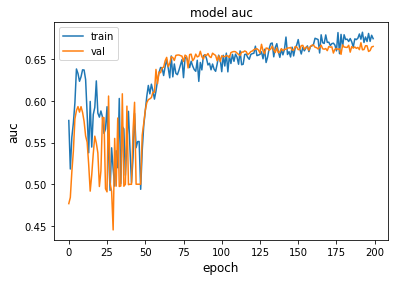

In [31]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [32]:
model.predict(X_test)

155/155 [==============================] - 0s 765us/step


array([[0.03088853],
       [0.02687662],
       [0.03052026],
       ...,
       [0.04898142],
       [0.04878054],
       [0.04821908]], dtype=float32)

In [33]:
from sklearn.metrics import roc_auc_score

2*roc_auc_score(y_test,model.predict(X_test))-1

155/155 [==============================] - 0s 842us/step


0.3410738041364887

In [34]:
from sklearn.metrics import roc_auc_score

test_gini = 2*roc_auc_score(y_test,model.predict(X_test))-1
train_gini = 2*roc_auc_score(y_train,model.predict(X_train))-1

print(f'Train GINI:{train_gini:0.3f}, Test GINI:{test_gini:0.3f}')

188/188 [==============================] - 0s 890us/step
Train GINI:0.384, Test GINI:0.341


In [35]:
model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


Tops out at 0.35....

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train))

188/188 [==============================] - 0s 802us/step


188/188 [==============================] - 0s 864us/step


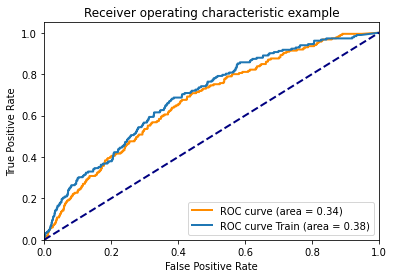

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train))

plt.figure()
lw = 2
roc = 2*roc_auc_score(y_test,model.predict(X_test))-1
roc_train = 2*roc_auc_score(y_train,model.predict(X_train))-1

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc,
)

plt.plot(
    fpr_train,
    tpr_train,
    #color="darkorange",
    lw=lw,
    label="ROC curve Train (area = %0.2f)" % roc_train,
)


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## 3.0 LTSM
Not even sure this is right..

In [41]:
from tensorflow.keras.layers import LSTM
from tensorflow import keras

lookback = 20
model = keras.Sequential([
    keras.layers.LSTM(20,input_shape=(21,5)),
    keras.layers.Dense(5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [42]:
import tensorflow as tf

metrics = [tf.metrics.AUC(name='auc')]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [43]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [44]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100
120/120 - 2s - loss: 0.2882 - auc: 0.4456 - val_loss: 0.2045 - val_auc: 0.4342 - 2s/epoch - 20ms/step
Epoch 2/100
120/120 - 1s - loss: 0.1624 - auc: 0.4637 - val_loss: 0.1670 - val_auc: 0.4307 - 588ms/epoch - 5ms/step
Epoch 3/100
120/120 - 1s - loss: 0.1427 - auc: 0.4415 - val_loss: 0.1631 - val_auc: 0.4478 - 628ms/epoch - 5ms/step
Epoch 4/100
120/120 - 1s - loss: 0.1391 - auc: 0.4530 - val_loss: 0.1621 - val_auc: 0.4892 - 574ms/epoch - 5ms/step
Epoch 5/100
120/120 - 1s - loss: 0.1377 - auc: 0.4791 - val_loss: 0.1609 - val_auc: 0.5048 - 577ms/epoch - 5ms/step
Epoch 6/100
120/120 - 1s - loss: 0.1367 - auc: 0.5173 - val_loss: 0.1605 - val_auc: 0.5274 - 585ms/epoch - 5ms/step
Epoch 7/100
120/120 - 1s - loss: 0.1361 - auc: 0.5260 - val_loss: 0.1593 - val_auc: 0.5614 - 575ms/epoch - 5ms/step
Epoch 8/100
120/120 - 1s - loss: 0.1354 - auc: 0.5667 - val_loss: 0.1593 - val_auc: 0.5598 - 587ms/epoch - 5ms/step
Epoch 9/100
120/120 - 1s - loss: 0.1350 - auc: 0.5777 - val_loss: 0.1589 -

Epoch 72/100
120/120 - 1s - loss: 0.1304 - auc: 0.6702 - val_loss: 0.1547 - val_auc: 0.6601 - 572ms/epoch - 5ms/step
Epoch 73/100
120/120 - 1s - loss: 0.1303 - auc: 0.6728 - val_loss: 0.1546 - val_auc: 0.6596 - 575ms/epoch - 5ms/step
Epoch 74/100
120/120 - 1s - loss: 0.1305 - auc: 0.6684 - val_loss: 0.1544 - val_auc: 0.6552 - 566ms/epoch - 5ms/step
Epoch 75/100
120/120 - 1s - loss: 0.1301 - auc: 0.6783 - val_loss: 0.1545 - val_auc: 0.6553 - 567ms/epoch - 5ms/step
Epoch 76/100
120/120 - 1s - loss: 0.1299 - auc: 0.6812 - val_loss: 0.1546 - val_auc: 0.6612 - 568ms/epoch - 5ms/step
Epoch 77/100
120/120 - 1s - loss: 0.1300 - auc: 0.6759 - val_loss: 0.1549 - val_auc: 0.6589 - 574ms/epoch - 5ms/step
Epoch 78/100
120/120 - 1s - loss: 0.1299 - auc: 0.6817 - val_loss: 0.1543 - val_auc: 0.6593 - 571ms/epoch - 5ms/step
Epoch 79/100
120/120 - 1s - loss: 0.1298 - auc: 0.6797 - val_loss: 0.1552 - val_auc: 0.6572 - 572ms/epoch - 5ms/step
Epoch 80/100
120/120 - 1s - loss: 0.1298 - auc: 0.6828 - val_los

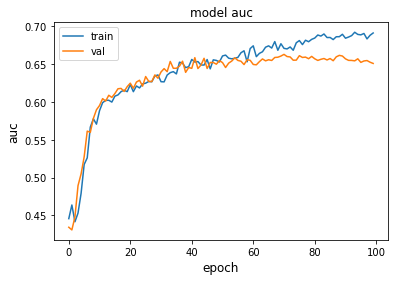

In [45]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

test_gini = 2*roc_auc_score(y_test,model.predict(X_test))-1
train_gini = 2*roc_auc_score(y_train,model.predict(X_train))-1

print(f'Train GINI:{train_gini:0.3f}, Test GINI:{test_gini:0.3f}')

188/188 [==============================] - 0s 2ms/step
Train GINI:0.401, Test GINI:0.307


188/188 [==============================] - 0s 2ms/step


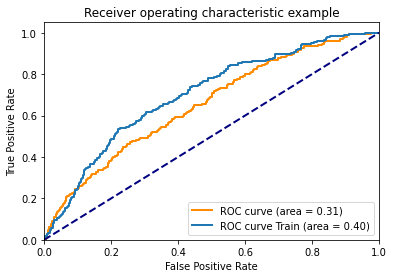

In [47]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train))

plt.figure()
lw = 2
roc = 2*roc_auc_score(y_test,model.predict(X_test))-1
roc_train = 2*roc_auc_score(y_train,model.predict(X_train))-1

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc,
)

plt.plot(
    fpr_train,
    tpr_train,
    #color="darkorange",
    lw=lw,
    label="ROC curve Train (area = %0.2f)" % roc_train,
)


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

## 4.0 Conv2D image
The image is essentialy the plot of the highs, lows, close, and open. Need to do some manipulation here.

In [48]:
X_train.shape

(6000, 21, 5)

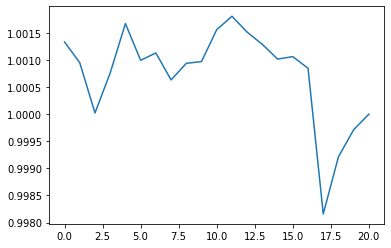

In [260]:
plt.plot(X_train[-1,:,1])
plt.show()

In [252]:
X_train[0,:,1].ravel()

array([0.99832505, 0.99769694, 0.9983041 , 0.9981785 , 0.9984298 ,
       0.9981785 , 0.9982622 , 0.9982413 , 0.99895316, 0.9992044 ,
       0.9990369 , 0.99909973, 0.99951845, 0.99945563, 0.9997697 ,
       0.9999372 , 0.9999372 , 1.0000838 , 0.9999581 , 1.0001885 ,
       1.        ], dtype=float32)

In [61]:
levels = np.arange(0.9,1.1,0.01)
len(levels)

21

In [241]:
levels = np.arange(0.996,1.001,0.0001)
levels = [-np.inf]+levels.tolist()+[np.inf]
n_levels = len(levels)
labels = np.arange(n_levels-1)

Y = pd.cut(X_train[0,:,1],levels,labels=labels[::-1])

y_resolution = len(levels)
X = np.arange(0,len(X_train[0,:,1]))

blank = np.zeros( (n_levels,21))
for n,(x,y) in enumerate(zip(X,Y)):
    blank[y,x] = X_train[0,:,1][n]

In [322]:
def convert_time_series_img(series,lower_bound,upper_bound,resolution):
    
    series = series.ravel()
    levels = np.arange(lower_bound,upper_bound,resolution)
    levels = [-np.inf]+levels.tolist()+[np.inf]
    n_levels = len(levels)
    labels = np.arange(n_levels-1)
    Y = pd.cut(series,levels,labels=labels[::-1])
    
    y_resolution = len(levels)
    X = np.arange(0,len(series))
    
    blank = np.zeros( (n_levels,21))
    for n,(x,y) in enumerate(zip(X,Y)):
        #blank[y,x] = series[n]
        blank[y,x] = 255
        
    return blank

In [328]:
def plot_time_series(series):
    np_img = convert_time_series_img(series,0.996,1.004,0.0001)
    fig, axes = plt.subplots(figsize=(10,5))
    axes.imshow(np_img)
    plt.show()

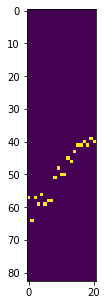

In [329]:
plot_time_series(X_train[0,:,1])

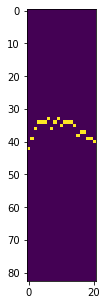

In [330]:
plot_time_series(X_train[20,:,1])

In [338]:
imgs = [convert_time_series_img(X_train[x,:,1],0.995,1.005,0.0001) for x in range(len(X_train))]

In [339]:
import numpy as np
from PIL import Image

imgs = [convert_time_series_img(X_train[x,:,1],0.997,1.003,0.0001) for x in range(len(X_train))]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

Hoooooo-rah!!!! Looks like its working.

![SegmentLocal](array.gif "segment")

## 5.0 LTSM with Conv 1D

In [122]:
from tensorflow.keras.layers import LSTM
from tensorflow import keras

lookback = 20
model = keras.Sequential([
    keras.layers.ConvLSTM1D(36,3,
                        activation='sigmoid',
                        input_shape=(X_train.shape[1],X_train.shape[2]),padding="valid",
                        kernel_regularizer=tf.keras.regularizers.l2(l=.05)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    keras.layers.Dense(5),
    keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

ValueError: Input 0 of layer "conv_lstm1d_11" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (None, 21, 5)

In [123]:
import tensorflow as tf

metrics = [tf.metrics.AUC(name='auc')]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [124]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [125]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=2,validation_data=(X_test,y_test))

Epoch 1/100


ValueError: in user code:

    File "C:\Users\cemly\anaconda3\envs\stonks\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\cemly\anaconda3\envs\stonks\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\cemly\anaconda3\envs\stonks\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\cemly\anaconda3\envs\stonks\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\cemly\anaconda3\envs\stonks\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\cemly\anaconda3\envs\stonks\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_22" is incompatible with the layer: expected shape=(None, None, 21, 5), found shape=(50, 21, 5)


In [111]:
X_train.shape[2]

5

###### running a simulation

In [ ]:
results_df.test_predictions>0.01

In [ ]:
np.arange(0.0,0.7,0.01)

In [ ]:
results_df[results_df.test_predictions>0.0].growth.sum()

In [ ]:
results_df.growth.plot()

In [ ]:
profit = list()
cutoff = list()
for i in np.arange(0.0,0.07,0.001):
    p = results_df[results_df.test_predictions>i].growth.sum()
    profit.append(p)
    cutoff.append(i)
plt.plot(cutoff,profit,marker='x')
plt.ylabel('%Growth')
plt.show()

In [ ]:
results_df[results_df.test_predictions>0.001].growth.sum()

If you were to just buy when the model has a prob greater than 0.04 you would get a 5% return, which over 36 days ain't bad.

Of course, this 10% figure will be reduced, and could even be eradicated by fees and spread in the buy sell.

In [ ]:
10000*1.05**(15*12)

In [ ]:
results_df.groupby('test_predictions_bin')['growth'].agg(['count','sum','mean'])['sum'].plot(figsize=[20,5],marker='x')
plt.ylabel('Total Return')
plt.title('Total growth by band')
plt.show()

In [ ]:
results_df['test_predictions_bin'] = pd.qcut(results_df['test_predictions'],10)
results_df.groupby('test_predictions_bin')['growth'].agg(['count','sum','mean'])

In [ ]:
results_df.index.max()-results_df.index.min()

In [ ]:
results_df.groupby('test_predictions_bin')['test_results'].agg(['count','sum','mean'])['mean'].plot(figsize=[20,5],marker='x')
plt.ylabel('Rate')
plt.title('Probability growth>0.5% in the next ')
plt.show()

In [ ]:
0.005

Additional features?
- time since opening?
- interday movements

In [ ]:
growth_test